# Overview

In this example, segmentation was done on identifying the area  of blow hole in the magnetic tiles using deep learning approach.


The dataset is available from:

https://github.com/abin24/Magnetic-tile-defect-datasets 



And the deep learning model UNet is adapted from:

U-Net: Convolutional Networks for Biomedical Image Segmentation
(Ronneberger et al., 2015)
https://arxiv.org/abs/1505.04597


In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [2]:
## move to correct working directory #

%cd /content/gdrive/My Drive/magnetic_tiles_defects

/content/gdrive/My Drive/magnetic_tiles_defects


In [0]:
## libraries initialization #

import os
from os.path import join
import time
import numpy
from copy import copy
from tqdm import tqdm
from torchvision import datasets, models, transforms
import torch
from torch.utils.data import Dataset, DataLoader
from torch import autograd, optim
import torch.backends.cudnn as cudnn
import torch.nn as nn
from torch.utils import data
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from unet2D import UNet
import random
import pickle
import glob
import cv2

In [0]:
## get image path #

# initialization
img_path_raw = []

data_path = '/content/gdrive/My Drive/magnetic_tiles_defects/datasets/'

# path for image and mask
data_defect_blow_hole = os.path.join(data_path,'defects/img_blow_hole/img1/img_raw/')
data_defect_blow_hole_label = os.path.join(data_path,'defects/img_blow_hole/mask1/img_mask/')

dir_img_raw = data_defect_blow_hole
dir_img_mask = data_defect_blow_hole_label

# get path of image
for img_path_tem in glob.glob(dir_img_raw+"*.jpg"):

    img_path_raw.append(img_path_tem)



In [0]:
## split path to train, validate and test #

# get length of data
length_data = len(img_path_raw)

# get length of train, validate and test
length_train = numpy.int(length_data * 0.7)
length_validate = numpy.int(length_data * 0.2)
length_test = numpy.int(length_data * 0.1)

# create random index
rand_ind = random.sample(range(0, length_data), length_data)

# get path for train, validate and test
img_path_train = [img_path_raw[i] for i in rand_ind[:length_train]]
img_path_validate = [img_path_raw[i] for i in rand_ind[length_train:length_train+length_validate]]
img_path_test = [img_path_raw[i] for i in rand_ind[length_train+length_validate:]]



In [0]:
## custom class for dataset #

class custom_dataset(Dataset):
    """custom dataset"""

    def __init__(self, file_path, mask_dir):

        self.file_path = file_path
        self.mask_dir = mask_dir
        self.count = 0
        self.x_in_size = 256
        self.y_in_size = 256

    def __len__(self):
        return len(self.file_path)

    def __getitem__(self, idx):

        #print(self.count)
        sample_out = [None]*2

        # get file name with ext
        file_base_name = os.path.basename(self.file_path[self.count])

        # split file name and ext
        split_file_name = os.path.splitext(file_base_name)

        # get file name
        file_name = split_file_name[0]

        # mask path
        img_path_mask = self.mask_dir+file_name+'.png'

        img_raw_tem = cv2.imread(self.file_path[self.count])
        img_raw_tem = cv2.cvtColor(img_raw_tem, cv2.COLOR_BGR2RGB)
        img_raw_tem = cv2.resize(img_raw_tem,(self.x_in_size,self.y_in_size));
        img_raw_tem = numpy.rollaxis(img_raw_tem, 2, 0) 

        img_mask_tem = cv2.imread(img_path_mask)
        img_mask_tem = cv2.resize(img_mask_tem,(self.x_in_size,self.y_in_size));
        img_mask_tem = cv2.cvtColor(img_mask_tem, cv2.COLOR_BGR2GRAY)
        img_mask_tem = numpy.expand_dims(img_mask_tem, axis=0)

        sample_out[0] =  img_raw_tem
        sample_out[1] = img_mask_tem
        

        self.count += 1

        if self.count == len(self.file_path):
            self.count = 0 

        return sample_out

In [0]:
## initialize dataset and dataloader #

# train
defects_dataset_train = custom_dataset(img_path_train,dir_img_mask)

defects_dataloader_train = torch.utils.data.DataLoader(defects_dataset_train,
                                             batch_size=4, shuffle=False)

# validate
defects_dataset_validate = custom_dataset(img_path_validate,dir_img_mask)

defects_dataloader_validate = torch.utils.data.DataLoader(defects_dataset_validate,
                                             batch_size=4, shuffle=False)

# test
defects_dataset_test = custom_dataset(img_path_test,dir_img_mask)

defects_dataloader_test = torch.utils.data.DataLoader(defects_dataset_test,
                                             batch_size=4, shuffle=False)

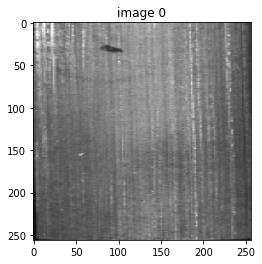

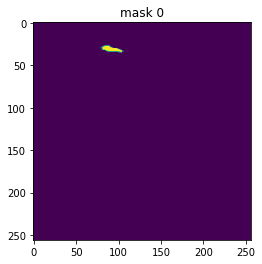

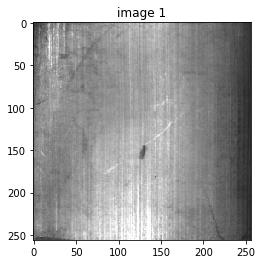

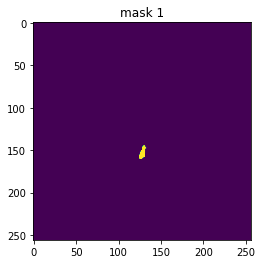

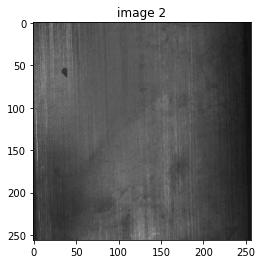

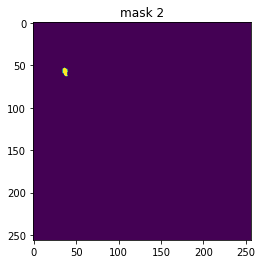

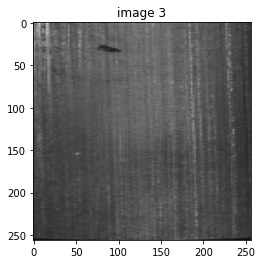

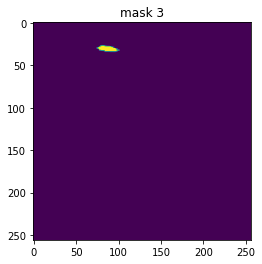

In [8]:
## visualize some sample images #

for i,img in enumerate(defects_dataloader_train):
    
    img_batch = img
    break

n = 0
for i in range(4):
    plt.figure(n)
    n+=1
    plt.title('image '+str(i))
    plt.imshow(img_batch[0][i].permute(1,2,0))

    plt.figure(n)
    n+=1
    plt.title('mask '+str(i))
    plt.imshow(img_batch[1][i][0])



In [9]:
## get device #

device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

print(device)

cuda


In [0]:
## training parameters initialization #

model = UNet(in_channels=3, out_channels=1, init_features=32)
#https://github.com/mateuszbuda/brain-segmentation-pytorch

model = model.to(device)

# epoch number
num_epochs = 100

# initial learning rate
initial_lr = 0.001

# optimizer
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# loss function
loss_criterion = nn.BCELoss()

# scheduler for decaying learning rate
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 1-(1/num_epochs))

In [0]:
## evaluation metric #

def numeric_score(prediction, groundtruth):

    prediction[prediction>0.9] = 1;
    prediction[prediction<=0.9] = 0;

    FP = numpy.float(numpy.sum((prediction == 1) & (groundtruth == 0)))
    FN = numpy.float(numpy.sum((prediction == 0) & (groundtruth == 1)))
    TP = numpy.float(numpy.sum((prediction == 1) & (groundtruth == 1)))
    TN = numpy.float(numpy.sum((prediction == 0) & (groundtruth == 0)))
    return FP, FN, TP, TN 
  
def accuracy(prediction, groundtruth):
    FP, FN, TP, TN = numeric_score(prediction, groundtruth)
    N = FP + FN + TP + TN
    accuracy = numpy.divide(TP + TN, N)
    return accuracy * 100.0

In [12]:
## training and validation sets iterations #

# initialization
best_loss = 999
c_loss = 0
p_loss = 0
v_p_count = 0
v_p = 5
plot_epoch = numpy.arange(0,num_epochs)
plot_train_loss = numpy.zeros((num_epochs))
plot_validate_loss = numpy.zeros((num_epochs))
plot_validate_accuracy = numpy.zeros((num_epochs))
epoch_count = 0

# loop in epochs
for epoch in tqdm(range(0,num_epochs)):

    # reduce learning rate usng scheduler
    scheduler.step()

    # get learning rate and print it
    lr = scheduler.get_lr()[0]

    print(' ')
    print('learn rate = ')
    print(lr)
    print(' ')

  
    # preallocate
    train_loss_total = 0.0
    train_accuracy_total = 0.0
    num_steps = 0
    
    # training loops
    for i, batch in enumerate(defects_dataloader_train):
        
        # set model to train mode
        model.train()

        # get train and label from dataloader
        batch_train = batch[0]
        
        batch_label = batch[1]
        batch_label[batch_label>0] = 1
        

        # convert to cuda 
        batch_train_in = batch_train.to(device,dtype=torch.float)
        batch_label_in = batch_label.to(device,dtype=torch.float)

        # Clean existing gradients
        optimizer.zero_grad()

        # forward pass of model
        predict_out = model(batch_train_in)

        # compute loss
        loss = loss_criterion(predict_out, batch_label_in)

        # add to total loss
        train_loss_total += loss.item()

        # backpropagation of gradients
        loss.backward()
        
        # update the parameters in optimizer
        optimizer.step()
        
        # get training accuracy
        train_accuracy_batch  = accuracy(predict_out.cpu().detach().numpy(), 
                              batch_label_in.cpu().detach().numpy())
        
        # increase training accuracy
        train_accuracy_total += train_accuracy_batch

        # increase iteration count
        num_steps += 1

    # get training loss
    train_loss = train_loss_total / num_steps

    # get training accuracy
    train_accuracy = train_accuracy_total / num_steps
    
    # get values for plotting
    plot_train_loss[epoch] = train_loss

    ## validation step #########################################################

    # set model to evaluation mode
    model.eval()

    # preallocate
    validate_loss_total = 0.0
    validate_accuracy_total = 0.0
    num_steps = 0

    for i, batch in enumerate(defects_dataloader_validate):
        
        # get validate and label from dataloader
        batch_validate = batch[0]
        
        batch_validate_label = batch[1]
        batch_validate_label[batch_validate_label>0] = 1

        # no grad in validation
        with torch.no_grad():

            # convert to cuda 
            batch_validate_in = batch_validate.to(device,dtype=torch.float)
            batch_validate_label_in = batch_validate_label.to(device,dtype=torch.float)


            # get forward pass
            predict_out_validate = model(batch_validate_in)

            # compute loss
            loss = loss_criterion(predict_out_validate, batch_validate_label_in)
            
            # get total validation loss
            validate_loss_total += loss.item()

            # get validation accuracy
            validate_accuracy_batch  = accuracy(predict_out_validate.cpu().detach().numpy(), 
                          batch_validate_label.cpu().detach().numpy())
            
            # increase validation accuracy
            validate_accuracy_total += validate_accuracy_batch

            # increase number of step
            num_steps += 1

    # get total validation loss
    validate_loss = validate_loss_total / num_steps

    # get validation accuracy
    validate_accuracy = validate_accuracy_total / num_steps

    # get values for plotting
    plot_validate_loss[epoch] = validate_loss
    plot_validate_accuracy[epoch] = validate_accuracy

    # increase epoch counter for reference purpose
    epoch_count+=1

    # update current and previous loss
    p_loss = copy(c_loss)
    c_loss = copy(validate_loss)

    # if current loss < best loss, save the model
    if c_loss < best_loss:
        v_p_count = 0
        best_loss = copy(validate_loss)
        print('  ')
        print('Saving low loss model ........................')
        print('  ')
        torch.save(model, 'model_best_loss_blow_hole.pt')

    # if current loss > previous loss, increase patience counter
    if c_loss > p_loss:
        v_p_count +=1

    # if validation patient reached, break from training
    if v_p_count > v_p:
        print('  ')
        print('Validate patience reached, break from training')
        print('  ')
        break

    print('\nTrain loss: {:.4f}, Training Accuracy: {:.4f} '.format(train_loss, train_accuracy))
    print('Val Loss: {:.4f}, Validation Accuracy: {:.4f} '.format(validate_loss, validate_accuracy))




  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


 
learn rate = 
0.00099
 
  
Saving low loss model ........................
  


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/


Train loss: 0.5145, Training Accuracy: 99.5649 
Val Loss: 0.4897, Validation Accuracy: 99.1894 
 
learn rate = 
0.0009801
 


  2%|▏         | 2/100 [01:45<1:58:58, 72.84s/it] 

  
Saving low loss model ........................
  

Train loss: 0.3474, Training Accuracy: 99.6785 
Val Loss: 0.3251, Validation Accuracy: 99.7228 
 
learn rate = 
0.0009702990000000001
 


  3%|▎         | 3/100 [01:49<1:24:03, 52.00s/it]

  
Saving low loss model ........................
  

Train loss: 0.2902, Training Accuracy: 99.6987 
Val Loss: 0.2628, Validation Accuracy: 99.7796 
 
learn rate = 
0.0009605960099999999
 


  4%|▍         | 4/100 [01:52<59:50, 37.40s/it]  

  
Saving low loss model ........................
  

Train loss: 0.2450, Training Accuracy: 99.6999 
Val Loss: 0.2525, Validation Accuracy: 99.7796 
 
learn rate = 
0.0009509900498999999
 


  5%|▌         | 5/100 [01:56<43:03, 27.20s/it]

  
Saving low loss model ........................
  

Train loss: 0.2072, Training Accuracy: 99.6999 
Val Loss: 0.2102, Validation Accuracy: 99.7796 
 
learn rate = 
0.000941480149401
 


  6%|▌         | 6/100 [01:59<31:23, 20.04s/it]

  
Saving low loss model ........................
  

Train loss: 0.1769, Training Accuracy: 99.6999 
Val Loss: 0.1736, Validation Accuracy: 99.7796 
 
learn rate = 
0.0009320653479069899
 


  7%|▋         | 7/100 [02:02<23:17, 15.02s/it]

  
Saving low loss model ........................
  

Train loss: 0.1515, Training Accuracy: 99.6999 
Val Loss: 0.1391, Validation Accuracy: 99.7796 
 
learn rate = 
0.0009227446944279201
 


  8%|▊         | 8/100 [02:06<17:39, 11.51s/it]

  
Saving low loss model ........................
  

Train loss: 0.1294, Training Accuracy: 99.6999 
Val Loss: 0.1145, Validation Accuracy: 99.7796 
 
learn rate = 
0.0009135172474836409
 


  9%|▉         | 9/100 [02:09<13:46,  9.08s/it]

  
Saving low loss model ........................
  

Train loss: 0.1105, Training Accuracy: 99.6999 
Val Loss: 0.0979, Validation Accuracy: 99.7796 
 
learn rate = 
0.0009043820750088044
 


 10%|█         | 10/100 [02:12<11:01,  7.34s/it]

  
Saving low loss model ........................
  

Train loss: 0.0947, Training Accuracy: 99.6999 
Val Loss: 0.0887, Validation Accuracy: 99.7796 
 
learn rate = 
0.0008953382542587164
 


 11%|█         | 11/100 [02:16<09:05,  6.13s/it]

  
Saving low loss model ........................
  

Train loss: 0.0813, Training Accuracy: 99.6999 
Val Loss: 0.0784, Validation Accuracy: 99.7796 
 
learn rate = 
0.0008863848717161292
 


 12%|█▏        | 12/100 [02:19<07:42,  5.25s/it]


Train loss: 0.0713, Training Accuracy: 99.6999 
Val Loss: 0.0948, Validation Accuracy: 99.7796 
 
learn rate = 
0.0008775210229989679
 


 13%|█▎        | 13/100 [02:22<06:48,  4.69s/it]

  
Saving low loss model ........................
  

Train loss: 0.0638, Training Accuracy: 99.6999 
Val Loss: 0.0703, Validation Accuracy: 99.7796 
 
learn rate = 
0.0008687458127689783
 


 14%|█▍        | 14/100 [02:25<06:08,  4.29s/it]

  
Saving low loss model ........................
  

Train loss: 0.0568, Training Accuracy: 99.6999 
Val Loss: 0.0520, Validation Accuracy: 99.7796 
 
learn rate = 
0.0008600583546412885
 
  
Saving low loss model ........................
  


 15%|█▌        | 15/100 [02:29<05:42,  4.03s/it]


Train loss: 0.0507, Training Accuracy: 99.6999 
Val Loss: 0.0483, Validation Accuracy: 99.7796 
 
learn rate = 
0.0008514577710948756
 


 16%|█▌        | 16/100 [02:32<05:19,  3.81s/it]

  
Saving low loss model ........................
  

Train loss: 0.0453, Training Accuracy: 99.6999 
Val Loss: 0.0424, Validation Accuracy: 99.7796 
 
learn rate = 
0.0008429431933839268
 


 17%|█▋        | 17/100 [02:35<05:03,  3.66s/it]

  
Saving low loss model ........................
  

Train loss: 0.0406, Training Accuracy: 99.6999 
Val Loss: 0.0404, Validation Accuracy: 99.7796 
 
learn rate = 
0.0008345137614500875
 


 18%|█▊        | 18/100 [02:39<04:51,  3.56s/it]

  
Saving low loss model ........................
  

Train loss: 0.0372, Training Accuracy: 99.6999 
Val Loss: 0.0335, Validation Accuracy: 99.7796 
 
learn rate = 
0.0008261686238355867
 


 19%|█▉        | 19/100 [02:42<04:43,  3.50s/it]

  
Saving low loss model ........................
  

Train loss: 0.0337, Training Accuracy: 99.6999 
Val Loss: 0.0317, Validation Accuracy: 99.7796 
 
learn rate = 
0.0008179069375972307
 


 20%|██        | 20/100 [02:46<04:36,  3.46s/it]

  
Saving low loss model ........................
  

Train loss: 0.0309, Training Accuracy: 99.6999 
Val Loss: 0.0291, Validation Accuracy: 99.7796 
 
learn rate = 
0.0008097278682212584
 


 21%|██        | 21/100 [02:49<04:29,  3.41s/it]

  
Saving low loss model ........................
  

Train loss: 0.0285, Training Accuracy: 99.6999 
Val Loss: 0.0274, Validation Accuracy: 99.7796 
 
learn rate = 
0.0008016305895390458
 


 22%|██▏       | 22/100 [02:52<04:27,  3.44s/it]

  
Saving low loss model ........................
  

Train loss: 0.0265, Training Accuracy: 99.6999 
Val Loss: 0.0258, Validation Accuracy: 99.7796 
 
learn rate = 
0.0007936142836436554
 


 23%|██▎       | 23/100 [02:56<04:23,  3.42s/it]

  
Saving low loss model ........................
  

Train loss: 0.0246, Training Accuracy: 99.6999 
Val Loss: 0.0225, Validation Accuracy: 99.7796 
 
learn rate = 
0.0007856781408072188
 


 24%|██▍       | 24/100 [02:59<04:16,  3.38s/it]

  
Saving low loss model ........................
  

Train loss: 0.0227, Training Accuracy: 99.6999 
Val Loss: 0.0215, Validation Accuracy: 99.7796 
 
learn rate = 
0.0007778213593991467
 


 25%|██▌       | 25/100 [03:02<04:11,  3.36s/it]

  
Saving low loss model ........................
  

Train loss: 0.0210, Training Accuracy: 99.6999 
Val Loss: 0.0206, Validation Accuracy: 99.7796 
 
learn rate = 
0.0007700431458051552
 


 26%|██▌       | 26/100 [03:06<04:07,  3.35s/it]

  
Saving low loss model ........................
  

Train loss: 0.0192, Training Accuracy: 99.7005 
Val Loss: 0.0190, Validation Accuracy: 99.7800 
 
learn rate = 
0.0007623427143471036
 


 27%|██▋       | 27/100 [03:09<04:03,  3.33s/it]

  
Saving low loss model ........................
  

Train loss: 0.0177, Training Accuracy: 99.7457 
Val Loss: 0.0185, Validation Accuracy: 99.8297 
 
learn rate = 
0.0007547192872036326
 


 28%|██▊       | 28/100 [03:12<04:00,  3.34s/it]

  
Saving low loss model ........................
  

Train loss: 0.0166, Training Accuracy: 99.8165 
Val Loss: 0.0171, Validation Accuracy: 99.8521 
 
learn rate = 
0.0007471720943315962
 


 29%|██▉       | 29/100 [03:16<03:57,  3.35s/it]

  
Saving low loss model ........................
  

Train loss: 0.0163, Training Accuracy: 99.8048 
Val Loss: 0.0164, Validation Accuracy: 99.8523 
 
learn rate = 
0.0007397003733882802
 


 30%|███       | 30/100 [03:19<03:52,  3.33s/it]

  
Saving low loss model ........................
  

Train loss: 0.0157, Training Accuracy: 99.7827 
Val Loss: 0.0150, Validation Accuracy: 99.8286 
 
learn rate = 
0.0007323033696543975
 


 31%|███       | 31/100 [03:22<03:49,  3.33s/it]

  
Saving low loss model ........................
  

Train loss: 0.0145, Training Accuracy: 99.8012 
Val Loss: 0.0144, Validation Accuracy: 99.8278 
 
learn rate = 
0.0007249803359578534
 


 32%|███▏      | 32/100 [03:26<03:48,  3.36s/it]

  
Saving low loss model ........................
  

Train loss: 0.0134, Training Accuracy: 99.8338 
Val Loss: 0.0135, Validation Accuracy: 99.8617 
 
learn rate = 
0.0007177305325982749
 
  
Saving low loss model ........................
  


 33%|███▎      | 33/100 [03:29<03:49,  3.42s/it]


Train loss: 0.0126, Training Accuracy: 99.8492 
Val Loss: 0.0129, Validation Accuracy: 99.8696 
 
learn rate = 
0.0007105532272722921
 


 34%|███▍      | 34/100 [03:33<03:45,  3.42s/it]

  
Saving low loss model ........................
  

Train loss: 0.0120, Training Accuracy: 99.8651 
Val Loss: 0.0123, Validation Accuracy: 99.8765 
 
learn rate = 
0.0007034476949995691
 


 35%|███▌      | 35/100 [03:36<03:41,  3.41s/it]

  
Saving low loss model ........................
  

Train loss: 0.0112, Training Accuracy: 99.8706 
Val Loss: 0.0119, Validation Accuracy: 99.8734 
 
learn rate = 
0.0006964132180495735
 


 36%|███▌      | 36/100 [03:39<03:36,  3.38s/it]

  
Saving low loss model ........................
  

Train loss: 0.0106, Training Accuracy: 99.8754 
Val Loss: 0.0116, Validation Accuracy: 99.8803 
 
learn rate = 
0.0006894490858690778
 


 37%|███▋      | 37/100 [03:43<03:32,  3.38s/it]

  
Saving low loss model ........................
  

Train loss: 0.0101, Training Accuracy: 99.8851 
Val Loss: 0.0109, Validation Accuracy: 99.8733 
 
learn rate = 
0.0006825545950103869
 


 38%|███▊      | 38/100 [03:46<03:28,  3.35s/it]

  
Saving low loss model ........................
  

Train loss: 0.0096, Training Accuracy: 99.8904 
Val Loss: 0.0105, Validation Accuracy: 99.8806 
 
learn rate = 
0.0006757290490602831
 


 39%|███▉      | 39/100 [03:49<03:21,  3.31s/it]


Train loss: 0.0094, Training Accuracy: 99.8906 
Val Loss: 0.0106, Validation Accuracy: 99.8883 
 
learn rate = 
0.0006689717585696802
 


 40%|████      | 40/100 [03:52<03:16,  3.27s/it]


Train loss: 0.0094, Training Accuracy: 99.8813 
Val Loss: 0.0108, Validation Accuracy: 99.8766 
 
learn rate = 
0.0006622820409839835
 


 41%|████      | 41/100 [03:56<03:13,  3.28s/it]

  
Saving low loss model ........................
  

Train loss: 0.0089, Training Accuracy: 99.8906 
Val Loss: 0.0099, Validation Accuracy: 99.8853 
 
learn rate = 
0.0006556592205741436
 


 42%|████▏     | 42/100 [03:59<03:11,  3.30s/it]

  
Saving low loss model ........................
  

Train loss: 0.0083, Training Accuracy: 99.8905 
Val Loss: 0.0093, Validation Accuracy: 99.8914 
 
learn rate = 
0.0006491026283684022
 


 43%|████▎     | 43/100 [04:02<03:09,  3.32s/it]

  
Saving low loss model ........................
  

Train loss: 0.0080, Training Accuracy: 99.8995 
Val Loss: 0.0090, Validation Accuracy: 99.8873 
 
learn rate = 
0.0006426116020847181
 


 44%|████▍     | 44/100 [04:06<03:05,  3.32s/it]

  
Saving low loss model ........................
  

Train loss: 0.0076, Training Accuracy: 99.9051 
Val Loss: 0.0087, Validation Accuracy: 99.8866 
 
learn rate = 
0.000636185486063871
 


 45%|████▌     | 45/100 [04:09<03:02,  3.32s/it]

  
Saving low loss model ........................
  

Train loss: 0.0074, Training Accuracy: 99.9030 
Val Loss: 0.0085, Validation Accuracy: 99.8935 
 
learn rate = 
0.0006298236312032323
 


 46%|████▌     | 46/100 [04:12<02:59,  3.33s/it]

  
Saving low loss model ........................
  

Train loss: 0.0072, Training Accuracy: 99.9036 
Val Loss: 0.0083, Validation Accuracy: 99.8924 
 
learn rate = 
0.0006235253948911999
 


 47%|████▋     | 47/100 [04:16<02:56,  3.32s/it]

  
Saving low loss model ........................
  

Train loss: 0.0070, Training Accuracy: 99.8998 
Val Loss: 0.0079, Validation Accuracy: 99.8895 
 
learn rate = 
0.0006172901409422879
 


 48%|████▊     | 48/100 [04:19<02:53,  3.33s/it]

  
Saving low loss model ........................
  

Train loss: 0.0066, Training Accuracy: 99.9088 
Val Loss: 0.0077, Validation Accuracy: 99.8938 
 
learn rate = 
0.000611117239532865
 


 49%|████▉     | 49/100 [04:22<02:49,  3.33s/it]

  
Saving low loss model ........................
  

Train loss: 0.0064, Training Accuracy: 99.9123 
Val Loss: 0.0075, Validation Accuracy: 99.8806 
 
learn rate = 
0.0006050060671375364
 


 50%|█████     | 50/100 [04:26<02:46,  3.33s/it]

  
Saving low loss model ........................
  

Train loss: 0.0062, Training Accuracy: 99.9149 
Val Loss: 0.0072, Validation Accuracy: 99.8913 
 
learn rate = 
0.000598956006466161
 


 51%|█████     | 51/100 [04:29<02:42,  3.32s/it]

  
Saving low loss model ........................
  

Train loss: 0.0060, Training Accuracy: 99.9143 
Val Loss: 0.0069, Validation Accuracy: 99.8919 
 
learn rate = 
0.0005929664464014994
 


 52%|█████▏    | 52/100 [04:32<02:39,  3.32s/it]

  
Saving low loss model ........................
  

Train loss: 0.0058, Training Accuracy: 99.9173 
Val Loss: 0.0069, Validation Accuracy: 99.8923 
 
learn rate = 
0.0005870367819374845
 


 53%|█████▎    | 53/100 [04:36<02:34,  3.29s/it]


Train loss: 0.0057, Training Accuracy: 99.9203 
Val Loss: 0.0069, Validation Accuracy: 99.8946 
 
learn rate = 
0.0005811664141181095
 


 54%|█████▍    | 54/100 [04:39<02:31,  3.30s/it]

  
Saving low loss model ........................
  

Train loss: 0.0055, Training Accuracy: 99.9181 
Val Loss: 0.0069, Validation Accuracy: 99.8938 
 
learn rate = 
0.0005753547499769285
 


 55%|█████▌    | 55/100 [04:42<02:27,  3.28s/it]


Train loss: 0.0054, Training Accuracy: 99.9155 
Val Loss: 0.0069, Validation Accuracy: 99.8940 
 
learn rate = 
0.0005696012024771592
 


 56%|█████▌    | 56/100 [04:46<02:25,  3.30s/it]

  
Saving low loss model ........................
  

Train loss: 0.0053, Training Accuracy: 99.9180 
Val Loss: 0.0066, Validation Accuracy: 99.8933 
 
learn rate = 
0.0005639051904523875
 


 57%|█████▋    | 57/100 [04:49<02:21,  3.29s/it]


Train loss: 0.0053, Training Accuracy: 99.9157 
Val Loss: 0.0069, Validation Accuracy: 99.8897 
 
learn rate = 
0.0005582661385478637
 


 58%|█████▊    | 58/100 [04:52<02:19,  3.32s/it]

  
Saving low loss model ........................
  

Train loss: 0.0050, Training Accuracy: 99.9178 
Val Loss: 0.0062, Validation Accuracy: 99.9015 
 
learn rate = 
0.0005526834771623851
 


 59%|█████▉    | 59/100 [04:56<02:17,  3.35s/it]

  
Saving low loss model ........................
  

Train loss: 0.0050, Training Accuracy: 99.9213 
Val Loss: 0.0060, Validation Accuracy: 99.9040 
 
learn rate = 
0.0005471566423907613
 


 60%|██████    | 60/100 [04:59<02:12,  3.32s/it]


Train loss: 0.0049, Training Accuracy: 99.9146 
Val Loss: 0.0063, Validation Accuracy: 99.8776 
 
learn rate = 
0.0005416850759668536
 


 61%|██████    | 61/100 [05:02<02:09,  3.33s/it]

  
Saving low loss model ........................
  

Train loss: 0.0051, Training Accuracy: 99.9095 
Val Loss: 0.0058, Validation Accuracy: 99.8996 
 
learn rate = 
0.0005362682252071849
 


 62%|██████▏   | 62/100 [05:05<02:05,  3.30s/it]


Train loss: 0.0048, Training Accuracy: 99.9118 
Val Loss: 0.0060, Validation Accuracy: 99.8807 
 
learn rate = 
0.0005309055429551132
 


 63%|██████▎   | 63/100 [05:09<02:02,  3.31s/it]

  
Saving low loss model ........................
  

Train loss: 0.0046, Training Accuracy: 99.9145 
Val Loss: 0.0056, Validation Accuracy: 99.8820 
 
learn rate = 
0.000525596487525562
 


 64%|██████▍   | 64/100 [05:12<01:59,  3.33s/it]

  
Saving low loss model ........................
  

Train loss: 0.0044, Training Accuracy: 99.9232 
Val Loss: 0.0055, Validation Accuracy: 99.8827 
 
learn rate = 
0.0005203405226503064
 


 65%|██████▌   | 65/100 [05:15<01:55,  3.31s/it]


Train loss: 0.0044, Training Accuracy: 99.9205 
Val Loss: 0.0056, Validation Accuracy: 99.8865 
 
learn rate = 
0.0005151371174238034
 


 66%|██████▌   | 66/100 [05:19<01:51,  3.27s/it]


Train loss: 0.0043, Training Accuracy: 99.9186 
Val Loss: 0.0056, Validation Accuracy: 99.8854 
 
learn rate = 
0.0005099857462495653
 


 67%|██████▋   | 67/100 [05:22<01:46,  3.24s/it]


Train loss: 0.0041, Training Accuracy: 99.9213 
Val Loss: 0.0058, Validation Accuracy: 99.9001 
 
learn rate = 
0.0005048858887870696
 


 68%|██████▊   | 68/100 [05:25<01:44,  3.26s/it]

  
Saving low loss model ........................
  

Train loss: 0.0041, Training Accuracy: 99.9199 
Val Loss: 0.0052, Validation Accuracy: 99.8941 
 
learn rate = 
0.0004998370298991989
 


 69%|██████▉   | 69/100 [05:28<01:40,  3.25s/it]


Train loss: 0.0041, Training Accuracy: 99.9246 
Val Loss: 0.0053, Validation Accuracy: 99.8867 
 
learn rate = 
0.000494838659600207
 


 70%|███████   | 70/100 [05:32<01:38,  3.29s/it]

  
Saving low loss model ........................
  

Train loss: 0.0040, Training Accuracy: 99.9216 
Val Loss: 0.0051, Validation Accuracy: 99.9006 
 
learn rate = 
0.000489890273004205
 


 71%|███████   | 71/100 [05:35<01:35,  3.30s/it]

  
Saving low loss model ........................
  

Train loss: 0.0040, Training Accuracy: 99.9202 
Val Loss: 0.0050, Validation Accuracy: 99.8879 
 
learn rate = 
0.00048499137027416283
 


 72%|███████▏  | 72/100 [05:38<01:32,  3.29s/it]

  
Saving low loss model ........................
  

Train loss: 0.0039, Training Accuracy: 99.9203 
Val Loss: 0.0046, Validation Accuracy: 99.9114 
 
learn rate = 
0.0004801414565714212
 


 73%|███████▎  | 73/100 [05:41<01:28,  3.26s/it]


Train loss: 0.0038, Training Accuracy: 99.9215 
Val Loss: 0.0054, Validation Accuracy: 99.8774 
 
learn rate = 
0.00047534004200570695
 


 74%|███████▍  | 74/100 [05:45<01:24,  3.26s/it]


Train loss: 0.0036, Training Accuracy: 99.9267 
Val Loss: 0.0051, Validation Accuracy: 99.8778 
 
learn rate = 
0.0004705866415856499
 


 75%|███████▌  | 75/100 [05:48<01:21,  3.25s/it]


Train loss: 0.0035, Training Accuracy: 99.9263 
Val Loss: 0.0050, Validation Accuracy: 99.8810 
 
learn rate = 
0.0004658807751697934
 


 76%|███████▌  | 76/100 [05:51<01:17,  3.24s/it]


Train loss: 0.0034, Training Accuracy: 99.9297 
Val Loss: 0.0048, Validation Accuracy: 99.8953 
 
learn rate = 
0.00046122196741809544
 


 77%|███████▋  | 77/100 [05:54<01:14,  3.22s/it]


Train loss: 0.0035, Training Accuracy: 99.9286 
Val Loss: 0.0049, Validation Accuracy: 99.8989 
 
learn rate = 
0.0004566097477439145
 


 78%|███████▊  | 78/100 [05:58<01:10,  3.21s/it]


Train loss: 0.0035, Training Accuracy: 99.9208 
Val Loss: 0.0060, Validation Accuracy: 99.8883 
 
learn rate = 
0.0004520436502664754
 


 79%|███████▉  | 79/100 [06:01<01:07,  3.22s/it]


Train loss: 0.0034, Training Accuracy: 99.9278 
Val Loss: 0.0053, Validation Accuracy: 99.8894 
 
learn rate = 
0.0004475232137638106
 


 80%|████████  | 80/100 [06:04<01:04,  3.20s/it]


Train loss: 0.0032, Training Accuracy: 99.9257 
Val Loss: 0.0050, Validation Accuracy: 99.9017 
 
learn rate = 
0.0004430479816261725
 


 81%|████████  | 81/100 [06:07<01:01,  3.22s/it]


Train loss: 0.0032, Training Accuracy: 99.9289 
Val Loss: 0.0048, Validation Accuracy: 99.9067 
 
learn rate = 
0.00043861750180991077
 


 82%|████████▏ | 82/100 [06:10<00:57,  3.22s/it]


Train loss: 0.0032, Training Accuracy: 99.9276 
Val Loss: 0.0048, Validation Accuracy: 99.9111 
 
learn rate = 
0.00043423132679181164
 


 83%|████████▎ | 83/100 [06:14<00:55,  3.26s/it]

  
Saving low loss model ........................
  

Train loss: 0.0031, Training Accuracy: 99.9305 
Val Loss: 0.0046, Validation Accuracy: 99.9157 
 
learn rate = 
0.0004298890135238935
 


 84%|████████▍ | 84/100 [06:17<00:52,  3.28s/it]


Train loss: 0.0033, Training Accuracy: 99.9238 
Val Loss: 0.0047, Validation Accuracy: 99.9006 
 
learn rate = 
0.0004255901233886546
 


 85%|████████▌ | 85/100 [06:20<00:49,  3.28s/it]


Train loss: 0.0034, Training Accuracy: 99.9145 
Val Loss: 0.0047, Validation Accuracy: 99.8964 
 
learn rate = 
0.00042133422215476804
 


 86%|████████▌ | 86/100 [06:24<00:46,  3.31s/it]

  
Saving low loss model ........................
  

Train loss: 0.0033, Training Accuracy: 99.9202 
Val Loss: 0.0045, Validation Accuracy: 99.9008 
 
learn rate = 
0.00041712087993322035
 


 87%|████████▋ | 87/100 [06:27<00:43,  3.34s/it]

  
Saving low loss model ........................
  

Train loss: 0.0030, Training Accuracy: 99.9196 
Val Loss: 0.0042, Validation Accuracy: 99.9080 
 
learn rate = 
0.0004129496711338882
 


 88%|████████▊ | 88/100 [06:30<00:40,  3.35s/it]

  
Saving low loss model ........................
  

Train loss: 0.0029, Training Accuracy: 99.9295 
Val Loss: 0.0041, Validation Accuracy: 99.9056 
 
learn rate = 
0.00040882017442254927
 


 89%|████████▉ | 89/100 [06:34<00:36,  3.30s/it]


Train loss: 0.0030, Training Accuracy: 99.9280 
Val Loss: 0.0046, Validation Accuracy: 99.8989 
 
learn rate = 
0.0004047319726783238
 


 90%|█████████ | 90/100 [06:37<00:32,  3.28s/it]


Train loss: 0.0028, Training Accuracy: 99.9317 
Val Loss: 0.0044, Validation Accuracy: 99.9094 
 
learn rate = 
0.00040068465295154055
 


 91%|█████████ | 91/100 [06:40<00:29,  3.28s/it]


Train loss: 0.0028, Training Accuracy: 99.9344 
Val Loss: 0.0043, Validation Accuracy: 99.9084 
 
learn rate = 
0.0003966778064220251
 


 92%|█████████▏| 92/100 [06:43<00:26,  3.26s/it]


Train loss: 0.0026, Training Accuracy: 99.9371 
Val Loss: 0.0042, Validation Accuracy: 99.9127 
 
learn rate = 
0.0003927110283578049
 


 93%|█████████▎| 93/100 [06:47<00:22,  3.25s/it]


Train loss: 0.0025, Training Accuracy: 99.9395 
Val Loss: 0.0042, Validation Accuracy: 99.9139 
 
learn rate = 
0.0003887839180742268
 


 94%|█████████▍| 94/100 [06:50<00:19,  3.24s/it]


Train loss: 0.0025, Training Accuracy: 99.9417 
Val Loss: 0.0043, Validation Accuracy: 99.9121 
 
learn rate = 
0.00038489607889348454
 


 95%|█████████▌| 95/100 [06:53<00:16,  3.24s/it]


Train loss: 0.0024, Training Accuracy: 99.9426 
Val Loss: 0.0043, Validation Accuracy: 99.9143 
 
learn rate = 
0.00038104711810454966
 


 96%|█████████▌| 96/100 [06:56<00:12,  3.24s/it]


Train loss: 0.0024, Training Accuracy: 99.9437 
Val Loss: 0.0044, Validation Accuracy: 99.9107 
 
learn rate = 
0.00037723664692350416
 


 97%|█████████▋| 97/100 [06:59<00:09,  3.22s/it]


Train loss: 0.0023, Training Accuracy: 99.9429 
Val Loss: 0.0043, Validation Accuracy: 99.9094 
 
learn rate = 
0.0003734642804542692
 


 98%|█████████▊| 98/100 [07:03<00:06,  3.21s/it]


Train loss: 0.0023, Training Accuracy: 99.9466 
Val Loss: 0.0043, Validation Accuracy: 99.9083 
 
learn rate = 
0.00036972963764972643
 


 99%|█████████▉| 99/100 [07:06<00:03,  3.22s/it]


Train loss: 0.0024, Training Accuracy: 99.9438 
Val Loss: 0.0043, Validation Accuracy: 99.9115 
 
learn rate = 
0.0003660323412732292
 


100%|██████████| 100/100 [07:09<00:00,  3.25s/it]

  
Saving low loss model ........................
  

Train loss: 0.0023, Training Accuracy: 99.9423 
Val Loss: 0.0039, Validation Accuracy: 99.9150 


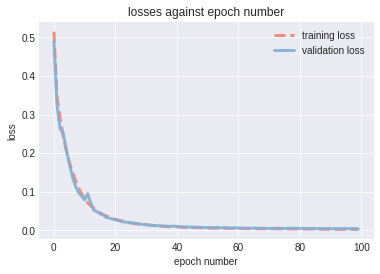

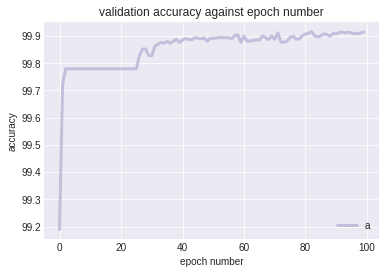

In [13]:
## plot the train and validation loss + accuracy #

palette = plt.get_cmap('Set3')
plt.style.use('seaborn-darkgrid')


f1 = plt.figure(1)
ax1 =plt.plot(plot_epoch[0:epoch_count],plot_train_loss[0:epoch_count], linestyle = '--',marker='', color=palette(3), linewidth=3, alpha=0.9)
ax1 =plt.plot(plot_epoch[0:epoch_count],plot_validate_loss[0:epoch_count], linestyle = '-',marker='', color=palette(4), linewidth=3, alpha=0.9)
ax1 = plt.xlabel('epoch number')
ax1 = plt.ylabel('loss')
ax1 = plt.gca().legend(('training loss','validation loss'),loc='upper right')
ax1 = plt.title('losses against epoch number')

f2 = plt.figure(2)
ax2 =plt.plot(plot_epoch[0:epoch_count],plot_validate_accuracy[0:epoch_count], linestyle = '-',marker='', color=palette(2), linewidth=3, alpha=0.9)
ax2 = plt.xlabel('epoch number')
ax2 = plt.ylabel('accuracy')
ax2 = plt.gca().legend(('accuracy'),loc='lower right')
ax2 = plt.title('validation accuracy against epoch number')


In [14]:
## save the model #

torch.save(model, data_path+'model_trained_blow_hole.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/

In [15]:
## testing set iterations #

plot_test_img = [None]*(3)
plot_test_mask = [None]*(3)
plot_test_predict = [None]*(3)


# set model to evaluation mode
model.eval()

# preallocate
test_accuracy_total = 0.0
test_loss_total = 0.0
num_steps = 0

for i, batch in enumerate(defects_dataloader_test):
    
    # get test and label from dataloader
    batch_test = batch[0]
    
    batch_test_label = batch[1]
    batch_test_label[batch_test_label>0] = 1

    plot_test_img[i] = batch_test
    plot_test_mask[i] = batch_test_label


    # no grad in test
    with torch.no_grad():

        # convert to cuda 
        batch_test_in = batch_test.to(device,dtype=torch.float)
        batch_test_label_in = batch_test_label.to(device,dtype=torch.float)

        # get forward pass
        predict_out_test = model(batch_test_in)
        plot_test_predict[i] = predict_out_test

        # compute loss
        loss = loss_criterion(predict_out_test, batch_test_label_in)
        
        # get total test loss
        test_loss_total += loss.item()

        # get test accuracy
        test_accuracy_batch  = accuracy(predict_out_test.cpu().detach().numpy(), 
                      batch_test_label.cpu().detach().numpy())

        # increase test accuracy
        test_accuracy_total += test_accuracy_batch

        # increase number of step
        num_steps += 1

    # get total validation loss
    test_loss = test_loss_total / num_steps

    # get validation accuracy
    test_accuracy  = test_accuracy_total / num_steps

    print('\nTest loss: {:.4f}, Test Accuracy: {:.4f} '.format(test_loss, test_accuracy))




Test loss: 0.0050, Test Accuracy: 99.8489 

Test loss: 0.0042, Test Accuracy: 99.8928 

Test loss: 0.0043, Test Accuracy: 99.9009 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

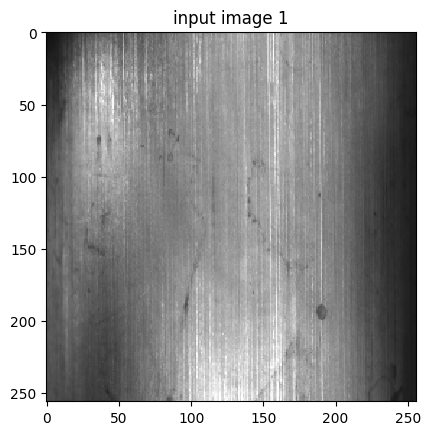

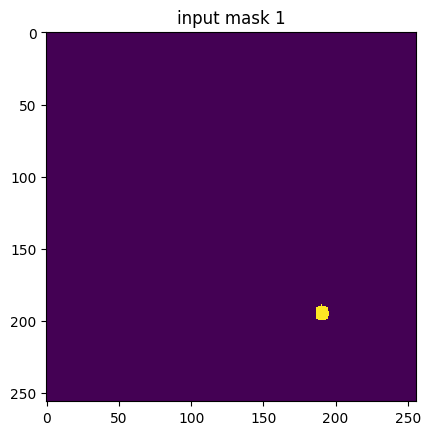

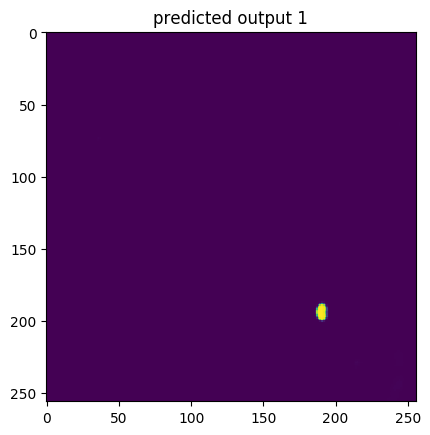

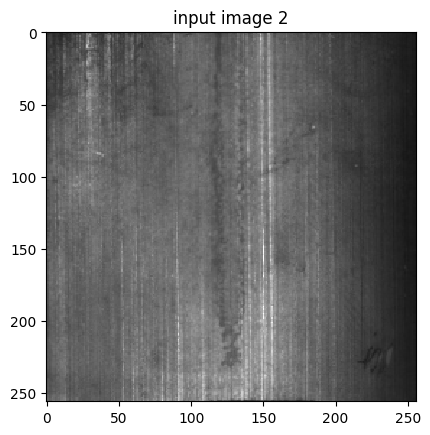

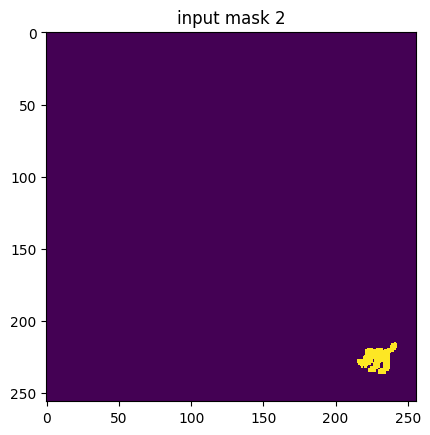

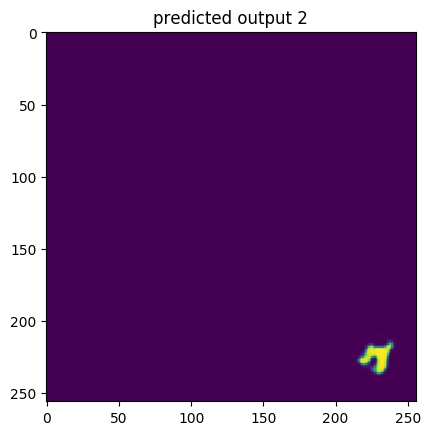

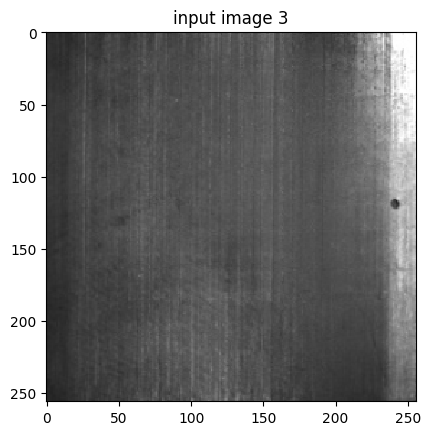

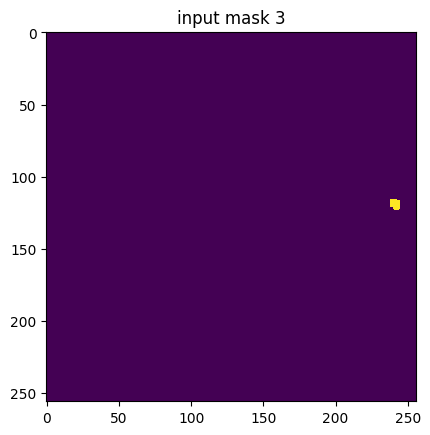

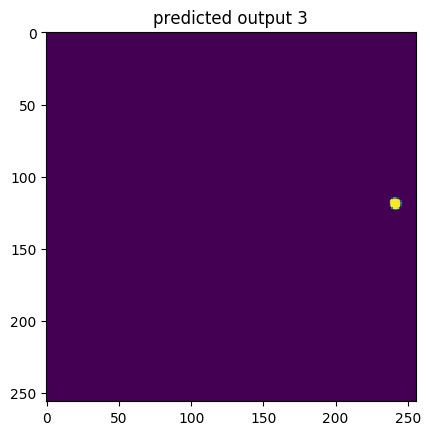

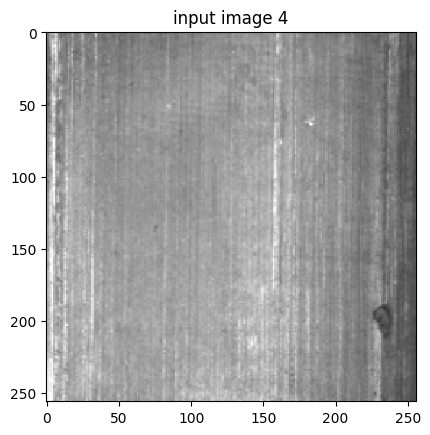

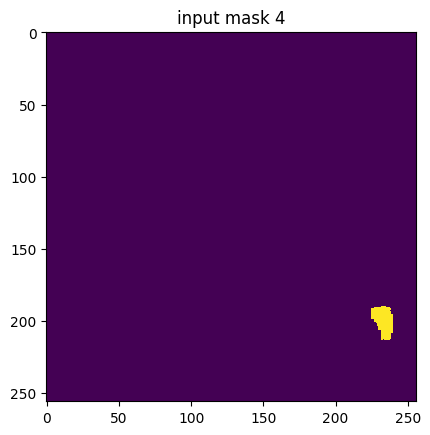

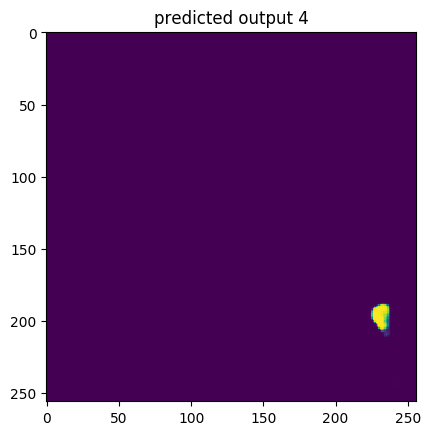

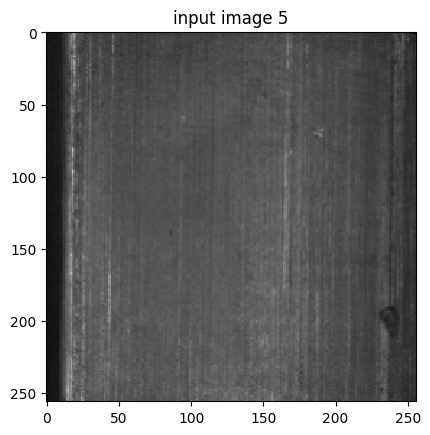

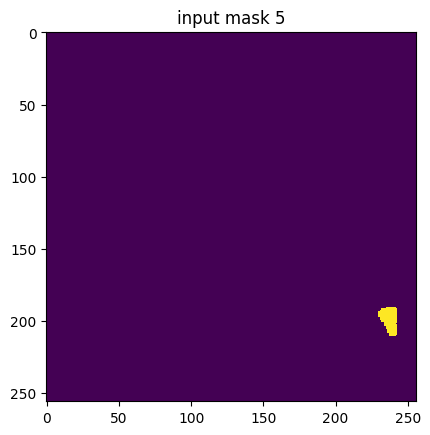

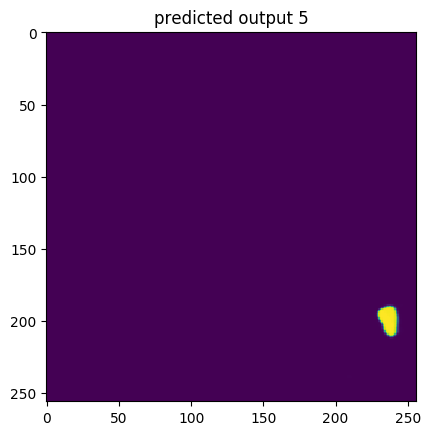

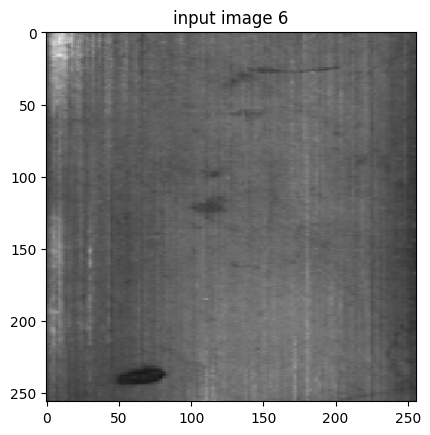

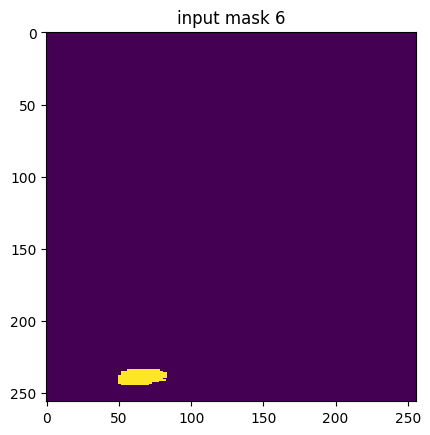

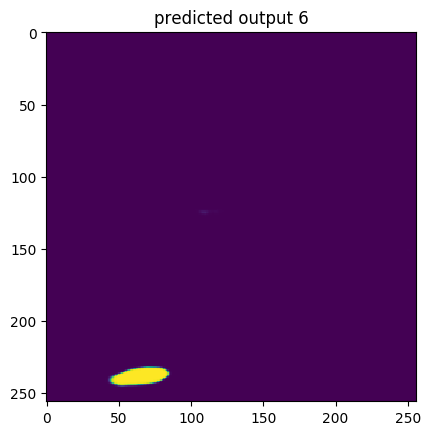

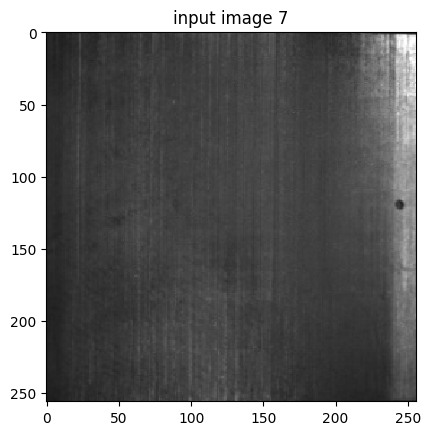

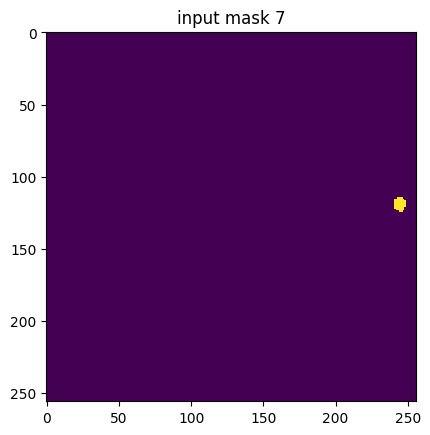

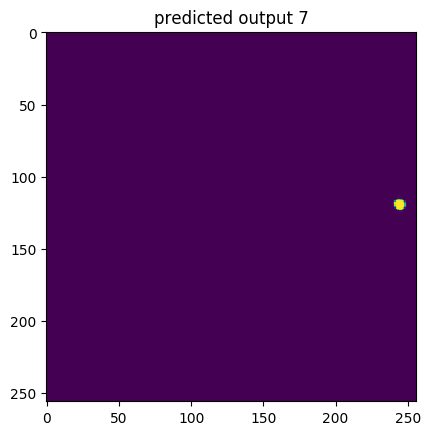

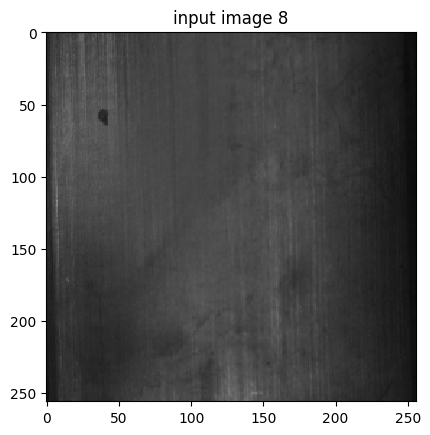

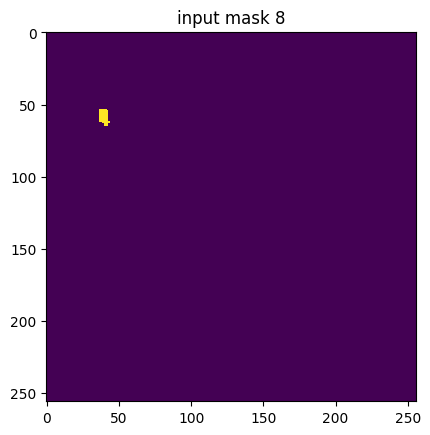

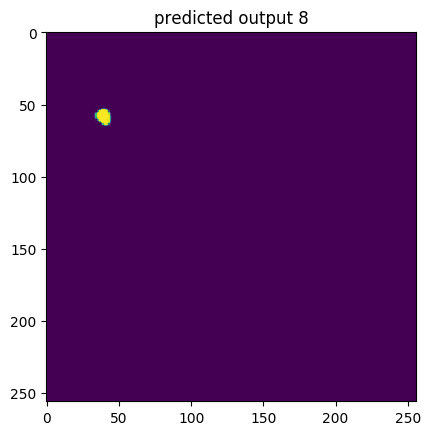

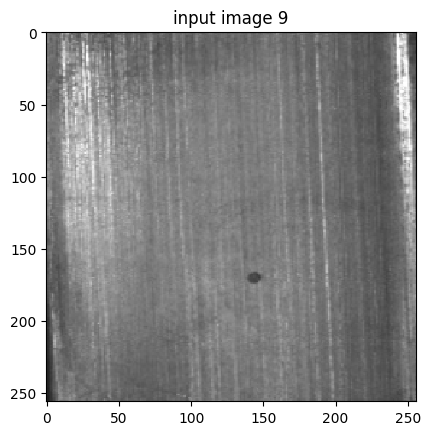

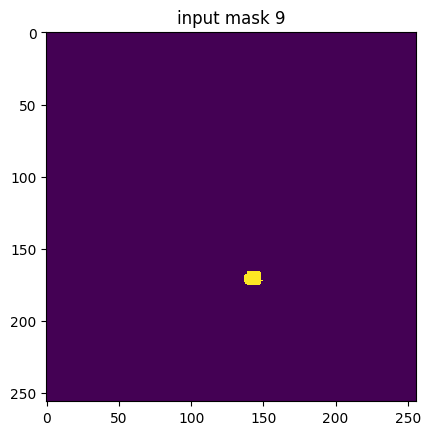

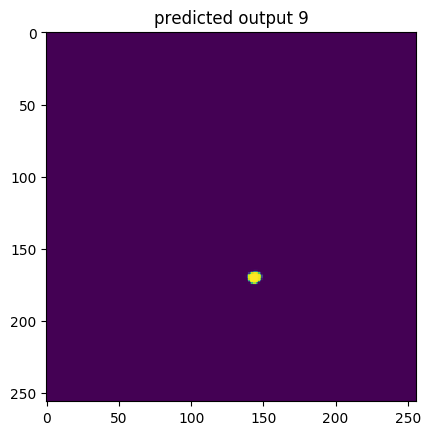

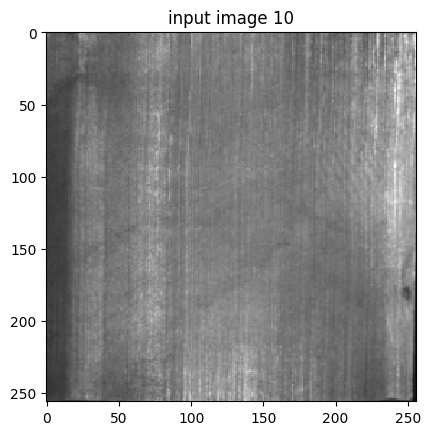

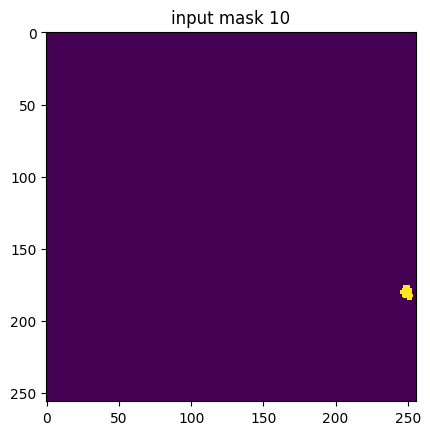

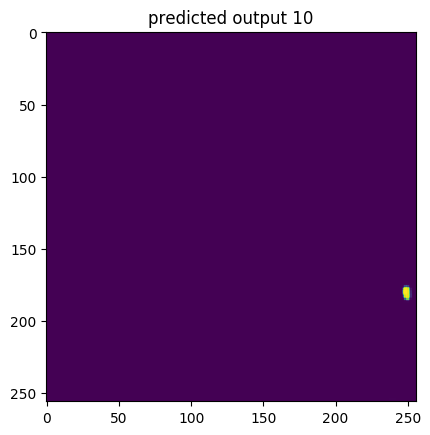

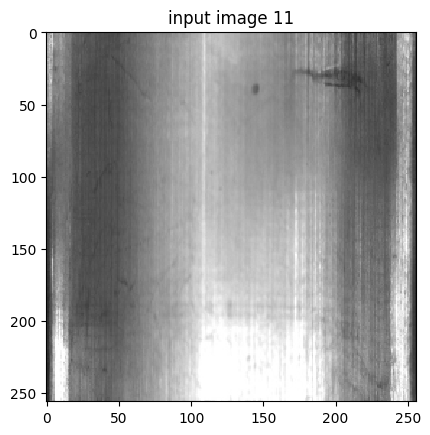

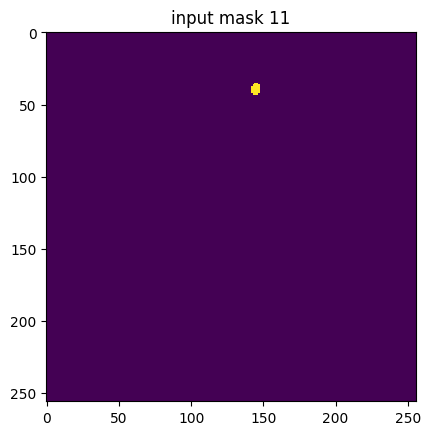

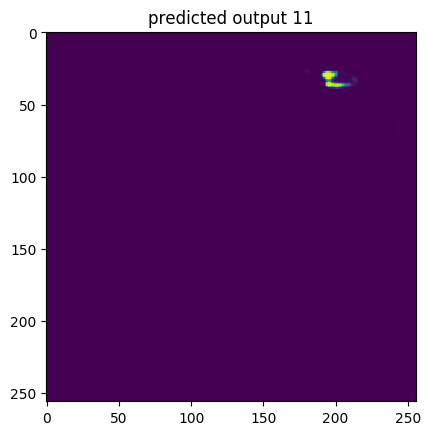

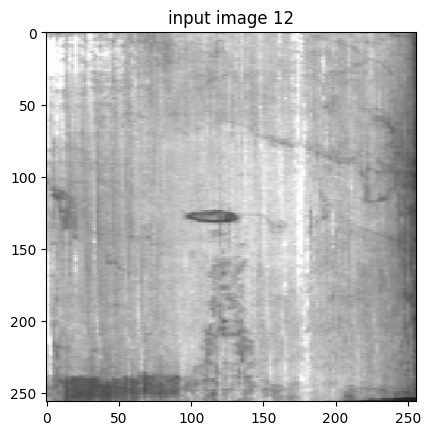

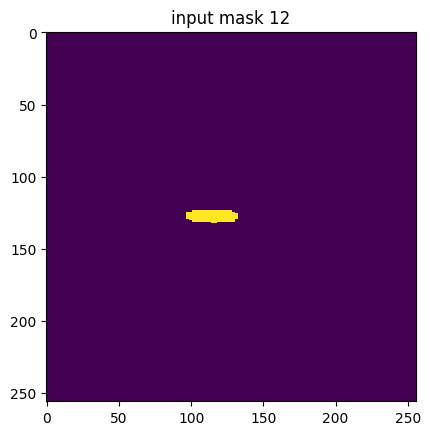

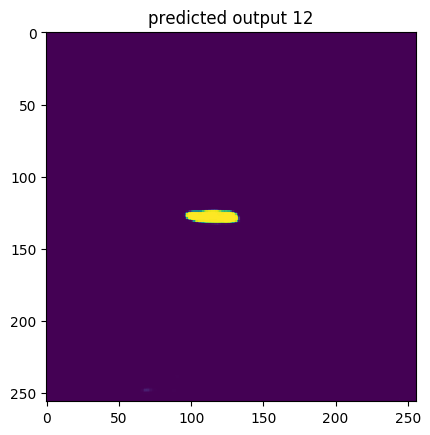

In [16]:
## plot test results #


plt.style.use('default')
n = 0
k = 1
for i in range(len(plot_test_img)):

    for j in range(plot_test_img[i].shape[0]):

        img_tem_ori = plot_test_img[i][j]
        img_tem_mask = plot_test_mask[i][j]
        img_tem_predict = plot_test_predict[i][j]

        plot_ori = numpy.uint8(img_tem_ori.permute(1, 2, 0))
        plot_mask = img_tem_mask[0]
        plot_predict = img_tem_predict[0].cpu().detach().numpy()

        plt.figure(n)
        plt.title('input image '+str(k))
        plt.imshow(plot_ori)
        n +=1
        plt.figure(n)
        plt.title('input mask '+str(k))
        plt.imshow(plot_mask)
        n +=1
        plt.figure(n)
        plt.title('predicted output '+str(k))
        plt.imshow(plot_predict)
        n +=1
        k+=1





prediction time for 1 image = 0.020857810974121094 seconds


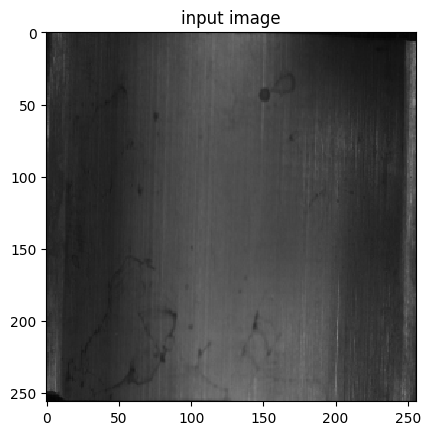

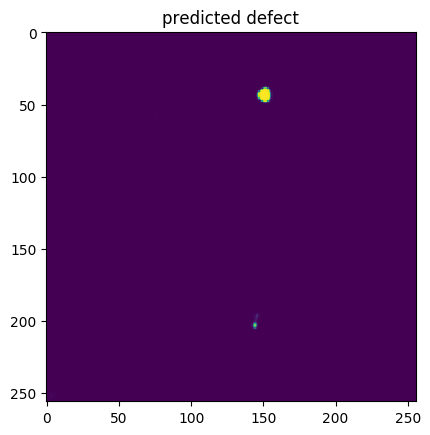

In [17]:
## predict some sample #

# start time
start_time = time.time()


# test data path
test_image_name = '/content/gdrive/My Drive/magnetic_tiles_defects/datasets/defects/img_blow_hole/img1/img_raw/exp1_num_3667.jpg'
#test_image_name = '/content/gdrive/My Drive/magnetic_tiles_defects/datasets/defects/img_blow_hole/img1/img_raw/exp1_num_308015.jpg'
#test_image_name = '/content/gdrive/My Drive/magnetic_tiles_defects/datasets/defects/img_blow_hole/img1/img_raw/exp2_num_297490.jpg'

x_in_size = 256
y_in_size = 256

# open test image
test_image = cv2.imread(test_image_name)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image = cv2.resize(test_image,(x_in_size,y_in_size));
test_image = numpy.rollaxis(test_image, 2, 0)
test_image = numpy.expand_dims(test_image, axis=0)

test_image_tensor = torch.from_numpy(test_image)

# convert to float
test_image_tensor = test_image_tensor.to(device,dtype=torch.float)

# no grad for test
with torch.no_grad():
        
        # eval model
        model.eval()
        
        # predict
        img_out = model(test_image_tensor)

# get output in numpy
img_out_numpy = img_out.cpu().detach().numpy()

# get image in numpy
img_out_ori = test_image_tensor[0].permute(1, 2, 0)
img_out_ori_plot = numpy.uint8(img_out_ori.cpu().detach().numpy())

elapsed_time = time.time() - start_time
print('prediction time for 1 image = '+str(elapsed_time)+' seconds')

# show original image
plt.imshow(img_out_ori_plot)
plt.title('input image')
plt.show()

# show detect area
plt.imshow(img_out_numpy[0][0])
plt.title('predicted defect')
plt.show()


